# D&D Gameplay Log Analysis Tutorial

This notebook demonstrates how to analyze Dungeons & Dragons gameplay logs

In [91]:
# Import required libraries
import json
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns
import numpy as np
from datetime import datetime
from pathlib import Path
import warnings
import os
import sys
import os
import inspect
from pathlib import Path
warnings.filterwarnings('ignore')

import analysis.data_loading as dl
import analysis.basic_metrics as basic
import analysis.creativity_metrics as creativity

# Set up plotting style
plt.style.use('default')
sns.color_palette("mako")
plt.rcParams['figure.dpi'] = 100

# Create Plots directory
plots_dir = Path('plots')
plots_dir.mkdir(exist_ok=True)
print(f"Created plots directory: {plots_dir}")

# Helper function for saving plots
def save_plot(filename):
    filepath = plots_dir / filename
    plt.savefig(filepath, dpi=300, bbox_inches='tight')
    print(f"Saved: {filepath}")

Created plots directory: plots


# Set calculation parameters

In [ ]:
CAMPAIGN_NAME = [
    '10391-guardians-of-gridori',
    'llm_campaign_10391-guardians-of-gridori_20250730_201553'
]
#source = CAMPAIGN_NAME
source = 'human'
max_campaigns = 10
force_refresh = False
scene_length = 175

# Calculate game log analyses

In [ ]:
#dfs = dl.load_campaigns(source=CAMPAIGN_NAME)
dfs = dl.load_campaings(source=source, max_campaigns = max_campaigns)

basic_metrics = basic.analyze_basic_metrics(dfs, force_refresh=force_refresh)

creativity_metrics = creativity.analyze_creativity(dfs,
                                                   force_refresh=force_refresh)

dsi_metrics = creativity.analyze_dsi(dfs,
                                     force_refresh=force_refresh,
                                     target_words=scene_length)


Analyzing campaigns: 100%|██████████| 2/2 [00:00<00:00, 35.01it/s]

💾 Saved 2 basic metrics results to cache


# Plot

In [204]:
def plot_histogram(data, colors=None, edgecolor='none', alpha=0.5, colormap='viridis', xlabel=None, bins=None, 
                   log_bins=False, log_y=False):
    """
    Plot histogram(s) with colors evenly spaced across a colormap.
    
    Parameters:
    data: Single array/list OR list of arrays/lists to plot as histograms
    colors (list): Specific colors (if None, uses colormap spacing)
    edgecolor (str): Edge color for bars (default: 'none')
    alpha (float): Transparency level (default: 0.5)
    colormap (str): Colormap name (default: 'viridis')
    xlabel (str): X-axis label (default: None, no label)
    bins: Number of bins (default: None uses matplotlib default)
    log_bins (bool): Use log-spaced bins and log x-axis (default: False)
    log_y (bool): Use log scale for y-axis (default: False)
    """
    plt.figure()
    
    # Auto-detect if data is a single array or list of arrays
    try:
        if isinstance(data[0], (list, np.ndarray)):
            data_list = data  # Already a list of arrays
        else:
            data_list = [data]  # Single array, wrap it in a list
    except:
        data_list = [data]
    
    # Remove NaN values from all datasets
    clean_data_list = []
    for dataset in data_list:
        clean_dataset = np.array(dataset)[~np.isnan(np.array(dataset))]
        clean_data_list.append(clean_dataset)
    
    n_plots = len(clean_data_list)
    
    if colors is None:
        cmap = cm.get_cmap(colormap)
        if n_plots == 1:
            colors = [cmap(0.5)]
        else:
            colors = [cmap(i / (n_plots - 1)) for i in range(n_plots)]
    
    # Calculate common bins across all datasets (now NaN-free)
    all_data = np.concatenate(clean_data_list)
    
    if len(all_data) == 0:
        raise ValueError("All data contains only NaN values")
    
    if log_bins:
        # Filter out zeros and negatives for log scale
        positive_data = all_data[all_data > 0]
        if len(positive_data) == 0:
            raise ValueError("log_bins=True requires positive values in data")
        
        min_val = np.min(positive_data)
        max_val = np.max(positive_data)
        
        if bins is None:
            bins = 50  # Default number of log bins
        
        common_bins = np.logspace(np.log10(min_val), np.log10(max_val), bins)
    else:
        # Linear bins
        if bins is None:
            bins = 50  # Default number of bins
        
        min_val = np.min(all_data)
        max_val = np.max(all_data)
        common_bins = np.linspace(min_val, max_val, bins)
    
    # Plot all histograms with the same bins (NaN-free data)
    for i, dataset in enumerate(clean_data_list):
        plt.hist(dataset, bins=common_bins, color=colors[i], edgecolor=edgecolor, alpha=alpha)
    
    # Set axis scales
    if log_bins:
        plt.xscale('log')
    
    if log_y:
        plt.yscale('log')
    
    sns.despine()
    plt.ylabel("Counts")
    
    if xlabel is not None:
        plt.xlabel(xlabel)
    
    # Style axes
    ax = plt.gca()
    ax.tick_params(colors='#4a4a4a', width=0.5)
    ax.spines['left'].set_color('#4a4a4a')
    ax.spines['left'].set_linewidth(0.5)
    ax.spines['bottom'].set_color('#4a4a4a')
    ax.spines['bottom'].set_linewidth(0.5)
    ax.xaxis.label.set_color('#4a4a4a')
    ax.yaxis.label.set_color('#4a4a4a')

10391-guardians-of-gridori
llm_campaign_10391-guardians-of-gridori_20250730_201553


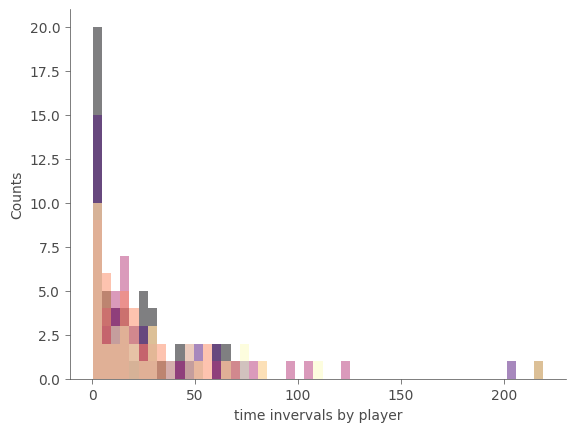

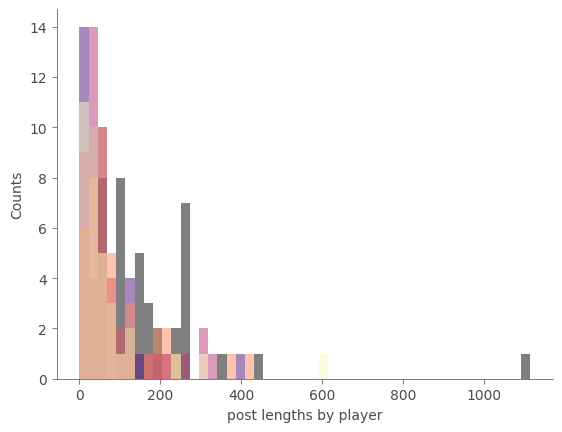

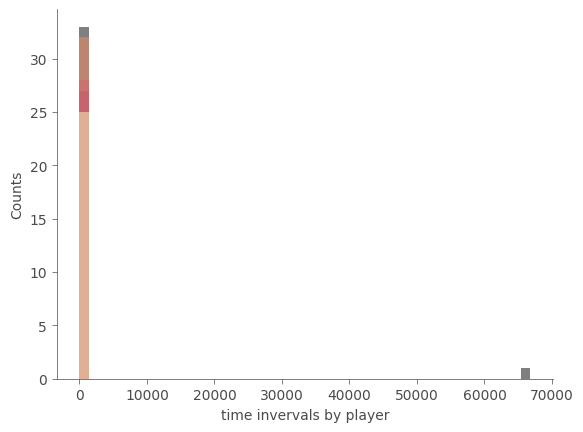

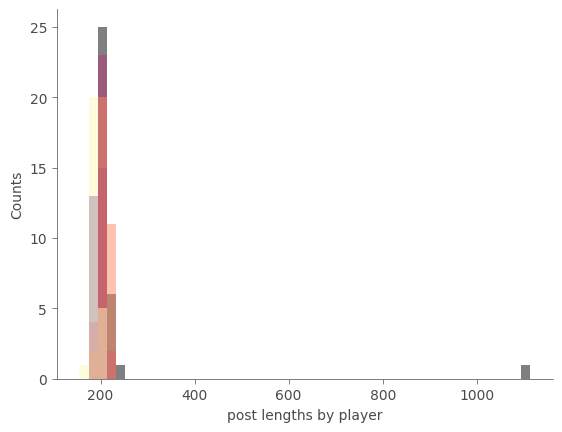

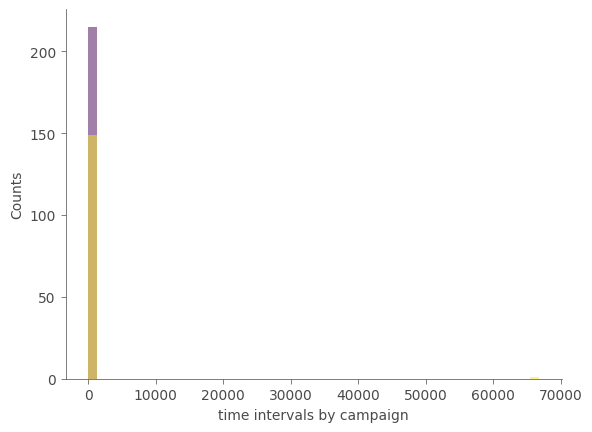

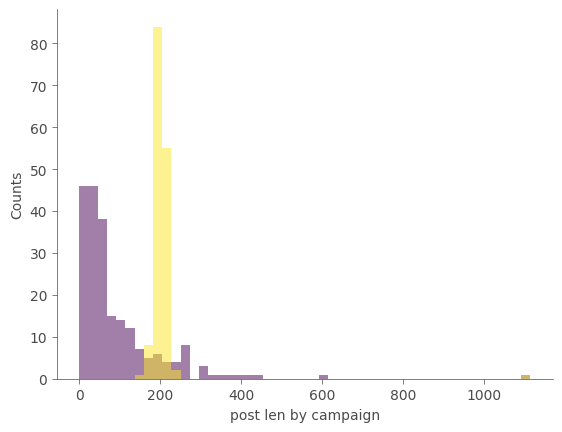

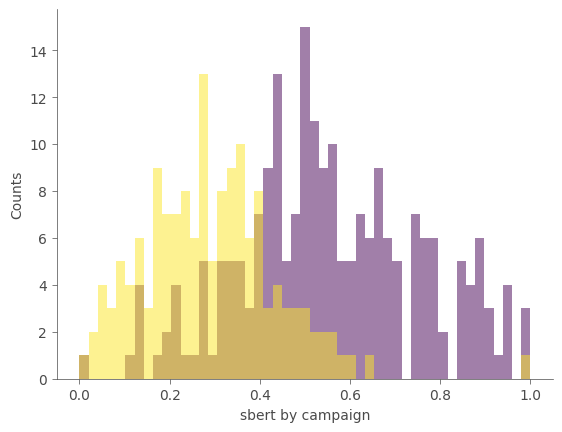

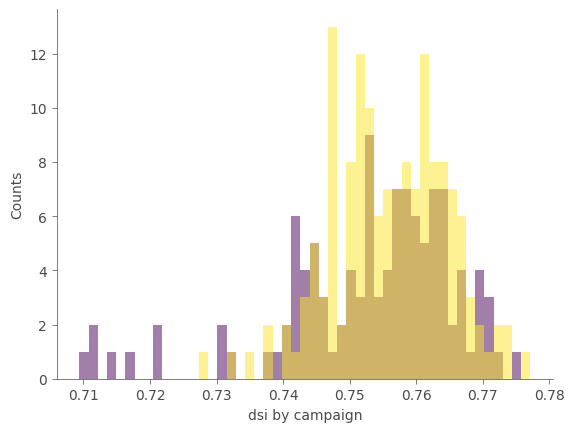

In [205]:
names = list(dfs.keys())

time_invervals_campaigns = []
post_len_campaigns = []
sentence_session_distances = []
dsi_scenes = []
for name in names:
    print(name)

    # get time interval distributions
    time_invervals_campaigns.append(basic_metrics[name]['time_intervals_overall']['overall']['intervals_data'])

    # get word count distritbutions
    post_len_campaigns.append(basic_metrics[name]['post_lengths_overall']['overall']['word_counts_data'])

    # get semantic distances (SBERT) distribtuions
    sentence_session_distances.append(np.array(creativity_metrics[name]['semantic_distances']))

    # get dsi distributions
    dsi_scenes.append(dsi_metrics[name]['scene_dsi_scores'])

    # plot time interval distributions per player
    player_names = basic_metrics[name]['time_intervals_by_player'].keys()
    time_intervals_player_list = []
    for player_name in player_names:
        time_intervals_player_list.append(
            basic_metrics[name]['time_intervals_by_player'][player_name]
            ['intervals_data'])
    plot_histogram(time_intervals_player_list, bins=50, xlabel='time invervals by player', colormap='magma')

    # plot word count distributions per player
    post_len_player_list = []
    for player_name in player_names:
        post_len_player_list.append(basic_metrics[name]['post_lengths_by_player'][player_name]['word_counts_data'])
    plot_histogram(post_len_player_list, bins=50, xlabel='post lengths by player', colormap='magma')


plot_histogram(time_invervals_campaigns, bins=50, xlabel='time intervals by campaign')
plot_histogram(post_len_campaigns, bins=50, xlabel='post len by campaign')
plot_histogram(sentence_session_distances, bins=50, xlabel='sbert by campaign')
plot_histogram(dsi_scenes, bins=50, xlabel='dsi by campaign')